## Overview

The project aims to build a multi-headed model that’s capable of detecting different types of of toxicity like threats, obscenity, insults, and identity-based hate, we will use a dataset of comments from Wikipedia’s talk page edits, collected by Kaggle. Improvements to the current model will hopefully help online discussion become more productive and respectful.

### Metrics

There are six labels, the results are evaluated on the mean column-wise ROC AUC. In other words, the score is the average of the individual AUCs of each predicted column. So the performance metrics for the model is AUC of each label.

##### Packages Load

In [1]:
# Packages for data processing and wrangling
import pandas as pd
import numpy as np
import re

# Packages for visulization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.offline as py 
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go

# Packages for feature engineering
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import chi2

# Packages for modeling
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score

## Data Description

##### Data Load

In [2]:
train = pd.read_csv('./data/train.csv')
test_X = pd.read_csv('./data/test.csv')
test_y = pd.read_csv('./data/test_labels.csv')
submission = pd.read_csv('./data/sample_submission.csv')

In [ ]:
test_y[test_y]

##### Data Glimpse

Firstly we can take a look at training data.

In [4]:
train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [7]:
train.shape

(159571, 8)

In training data, we have 159571 observations, for each observation, there is one unique id, and the predictor variable is the **comment_text**. The predicted variables are 6 labels that could show some toxic charateristics of the comment.

In [9]:
test_X.head()

,id,comment_text
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap..."
3,00017563c3f7919a,":If you have a look back at the source, the in..."
4,00017695ad8997eb,I don't anonymously edit articles at all.


In [13]:
train.describe()

,toxic,severe_toxic,obscene,threat,insult,identity_hate
count,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000
mean,0.095844,0.009996,0.052948,0.002996,0.049364,0.008805
std,0.294379,0.099477,0.223931,0.054650,0.216627,0.093420
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [5]:
test_y.head()

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,-1,-1,-1,-1,-1,-1
1,0000247867823ef7,-1,-1,-1,-1,-1,-1
2,00013b17ad220c46,-1,-1,-1,-1,-1,-1
3,00017563c3f7919a,-1,-1,-1,-1,-1,-1
4,00017695ad8997eb,-1,-1,-1,-1,-1,-1


In [21]:
submission.head()

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,0.5,0.5,0.5,0.5,0.5,0.5
1,0000247867823ef7,0.5,0.5,0.5,0.5,0.5,0.5
2,00013b17ad220c46,0.5,0.5,0.5,0.5,0.5,0.5
3,00017563c3f7919a,0.5,0.5,0.5,0.5,0.5,0.5
4,00017695ad8997eb,0.5,0.5,0.5,0.5,0.5,0.5


In [22]:
train.shape
test_X.shape

(153164, 2)

## Explanatory Data Analysis

We first check the predicted variable **Comment**.

In [15]:
train['comment_text'][0]

"Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27"

Check the length distribution of the comment.

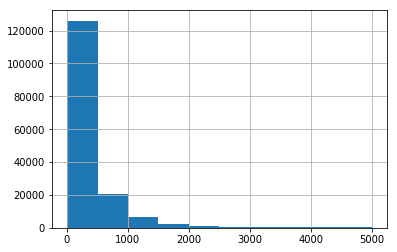

In [16]:
lens = train.comment_text.str.len()
lens.hist()

## Feature Engineering

In [3]:
# Vectorizing the text data
tokenizer = TfidfVectorizer(stop_words='english',
                            token_pattern='(?u)\\b[a-zA-Z]{1,}\\b')
train_feature = tokenizer.fit_transform(train.comment_text)
test_feature = tokenizer.transform(test_X.comment_text)

In [20]:
# Check tokens
tokenizer.get_feature_names()

['aa',
 'aaa',
 'aaaa',
 'aaaaa',
 'aaaaaaaa',
 'aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaany',
 'aaaaaaaaaah',
 'aaaaaaaaaahhhhhhhhhhhhhh',
 'aaaaaaaaadm',
 'aaaaaaaacfo',
 'aaaaaaaaczy',
 'aaaaaaaahhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhh',
 'aaaaaaaayui',
 'aaaaaaahhhhhhhhhhhhhhhhhhhhhhhh',
 'aaaaaaw',
 'aaaaah',
 'aaaah',
 'aaaannnnyyyywwwwhhhheeeerrrreeee',
 'aaaawwww',
 'aaages',
 'aaaghh',
 'aaah',
 'aaahhh',
 'aaahs',
 'aaai',
 'aaajade',
 'aaand',
 'aaarrrgggh',
 'aaaww',
 'aab',
 'aaba',
 'aaberg',
 'aabove',
 'aac',
 'aacargo',
 'aacd',
 'aachen',
 'aachi',
 'aacs',
 'aadd',
 'aademia',
 'aadil',
 'aadmi',
 'aadu',
 'aae',
 'aaets',
 'aaf',
 'aaffect',
 'aafia',
 'aafp',
 'aafs',
 'aagadu',
 'aage',
 'aagf',
 'aagin',
 'aah',
 'aahahahahahaha',
 'aahank',
 'aahh',
 'aahil',
 'aahoa',
 'aai',
 'aaiha',
 'aajacksoniv',
 'aajonus',
 'aakash',
 'aake',
 'aalborg',
 'aalertbot',
 'aaliya',
 'aaliyah',
 'aals',
 'aalst',
 'aam',
 'aami',
 'aamir',
 'aamirjamil'

## Modeling

Since there are six classes of predicted variables, we might need to create 6 classifiers, firstly we separate those labels.

In [29]:
train.columns

Index(['id', 'comment_text', 'toxic', 'severe_toxic', 'obscene', 'threat',
       'insult', 'identity_hate'],
      dtype='object')

In [30]:
labels = ['toxic', ' severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

In [28]:
# Build the model
lr_clf = LogisticRegression(solver='newton-cg')

# Fit the model
lr_clf.fit(train_feature, train['toxic'])

# Predict
lr_predicted_toxic = lr_clf.predict(test_feature)

# Check the model performance
lr_auc = roc_auc_score(test_y[test_y['toxic']!=-1].toxic,
                       lr_predicted_toxic[test_y['toxic']!=-1])

print(f"The AUC Score of Logistic Regression Model is {round(lr_auc,4)}")

The AUC Score of Logistic Regression Model is 0.8253


Then we try SVM 

In [24]:
# Build the model
svm_clf = SVC(kernel = 'linear')

# Fit the model
svm_clf.fit(train_feature, train['toxic'])

# Predict
svm_predicted_toxic = svm_clf.predict(test_feature)

# Check the model performance
svm_auc = roc_auc_score(test_y[test_y['toxic']!=-1].toxic,
                        svm_predicted_toxic[test_y['toxic']!=-1])

print(f"The AUC Score of SVM Model is {round(svm_auc,4)}")

The AUC Score of SVM Model is 0.8253


In [29]:
print(f"The AUC Score of SVM Model is {round(svm_auc,4)}")

The AUC Score of SVM Model is 0.8661


In [30]:
from sklearn.metrics import recall_score
recall_score(test_y[test_y['toxic']!=-1].toxic, predicted_toxic[test_y['toxic']!=-1])

0.6886699507389162

### Reference

https://www.kaggle.com/jhoward/nb-svm-strong-linear-baseline
